     ';## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Select one image and correct it for distortion

In [35]:
img = cv2.imread(images[11])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

# If found, add object points, image points
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
    cv2.imshow('img',img)
    cv2.imshow('und',undistorted)
    cv2.imwrite('../camera_cal/undistorted/undistorted2.jpg',undistorted)
    cv2.waitKey(500)



TypeError: integer argument expected, got float

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


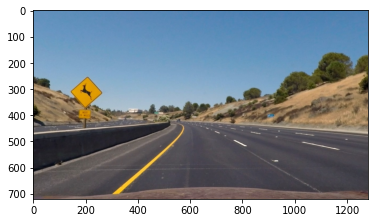

In [42]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy.interpolate import interp1d
%matplotlib inline

#reading in an image
image = mpimg.imread('../test_images/test2.jpg')
undist = cv2.undistort(image, mtx, dist, None, mtx)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(undist)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

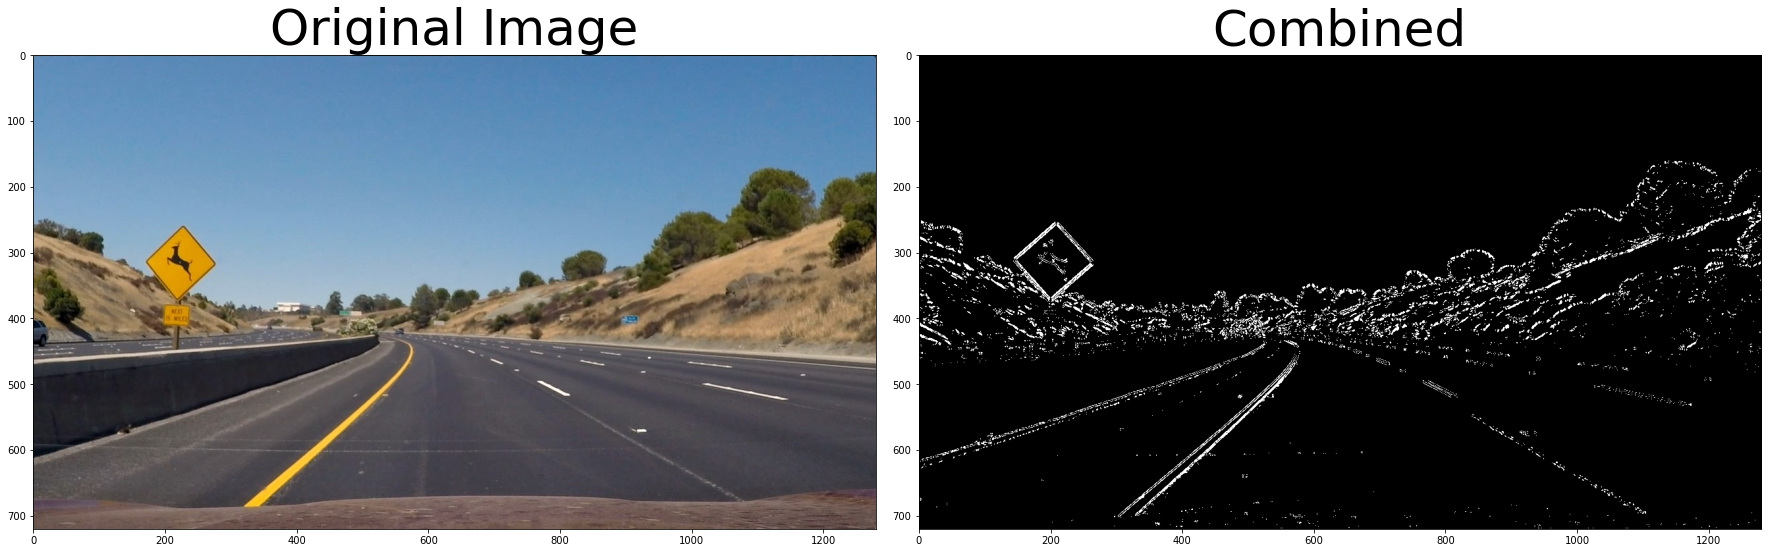

In [46]:
def abs_sobel_thresh(img, orient, sobel_kernel, thresh):
    # Calculate directional gradient
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Apply threshold
    return grad_binary

def mag_thresh(image, sobel_kernel, mag_thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*gradmag/np.max(gradmag))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    # 6) Return this mask as your binary_output image
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel, thresh):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    graddir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(graddir)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    # 6) Return this mask as your binary_output image
    dir_binary[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1
    return dir_binary

def channel_select(img,channel, thresh):
    if channel == 'r':
        channel = img[:,:,0]
    if channel == 'g':
        channel = hls[:,:,1]
    if channel == 'b':
        channel = hls[:,:,2]
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'h':
        channel = hls[:,:,0]
    if channel == 'l':
        channel = hls[:,:,1]
    if channel == 's':
        channel = hls[:,:,2]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(undist, sobel_kernel=ksize, thresh=(1.1, 1.3))
hls_binary = channel_select(undist, channel = 's',thresh=(30, 105))

combined = np.zeros_like(dir_binary)
combined[(gradx == 1) & (grady == 1) | (hls_binary==1)&((mag_binary == 1) & (dir_binary == 1))] = 1
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)